The purpose of this notebook is to get you comfortable with implementing the GasNet model proposed in the paper "Machine Vision for Natural Gas Methane Emissions Detection Using an Infared Camera"

- In this notebook, you will take the raw video files and generate training and test images (Binary: Leak, NonLeak)
- Experiment with various image preprocessiong methods as described in the research paper
- You will then train a CNN to classify the images as Leak or NonLeak
- Finally, you will evaluate the performance of the model on the test set

# Step 1: Load and Preprocess the Dataset

### Load the GasVid dataset
### Preprocess the data
### Split the dataset into training and test sets

In [1]:
# Imports

import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import pickle

from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, confusion_matrix

from sklearn.mixture import GaussianMixture


2023-10-25 00:15:19.285581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 00:15:19.285609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 00:15:19.285640: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting up Directories

In [2]:

# get all raw video data directories
dir_path = '/home/bestlab/Desktop/Squishy-Methane-Analysis/0 - GasNet/'

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

fake_frame_train_data_dir = '../MethaneGAN/fake_non_leak_images/'


# Step 2: Build the GasNet Convolutional Neural Network (CNN) Model

### Define the GasNet architecture (GasNet-2 as mentioned in the paper)
### Implement the model using TensorFlow/Keras

In [3]:
# Implement the model based on what is described in section 4.4 CNN model - GasNet


model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool 2
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


model.add(layers.Flatten())

model.add(layers.Dense(2400, activation='relu')) # adds a penalty to the model's loss function based on the size of the weights, discouraging overly complex models
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu')) #result right now are without it
model.add(layers.Dense(1, activation='sigmoid')) 


### Setting up Generator for Training, Validation, and Testing

In [4]:

val_split = 0.2
batch_size = 32
target_size = (240, 320)


train_datagen = ImageDataGenerator(
    # featurewise_center=True, #cant do this as need entire dataset to do it | need to figure out a way in doing this
    # featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
)

train_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

val_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


test_datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_generator = test_datagen.flow_from_directory(
    directory=frame_test_data_dir,
    class_mode='binary',
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

Found 278232 images belonging to 2 classes.
Found 69558 images belonging to 2 classes.
Found 236846 images belonging to 2 classes.


In [15]:
fake_train_datagen = ImageDataGenerator(
    # featurewise_center=True, #cant do this as need entire dataset to do it | need to figure out a way in doing this
    # featurewise_std_normalization=True,
    rescale=1. / 255,
)
fake_non_leak_generator = fake_train_datagen.flow_from_directory(
    directory=fake_frame_train_data_dir,
    class_mode="binary",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks"]

)

def combined_generator(gen1, gen2):
    while True:
        X1, y1 = next(gen1)
        X2, y2 = next(gen2)
        yield np.concatenate([X1, X2], axis=0), np.concatenate([y1, y2], axis=0)

combined_train_generator = combined_generator(train_generator, fake_non_leak_generator)


Found 253827 images belonging to 1 classes.


### Data Visualization (Confusion Matrix and ROC Curves)

In [5]:
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, num_batches, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_batches = num_batches

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        batch_num = 0
        for data, true_label in self.validation_data:
            batch_pred = self.model.predict(data, verbose=0)
            y_pred.append(batch_pred)
            y_true.append(true_label)

            if batch_num >= self.num_batches:
                break
            batch_num += 1

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        threshold = 0.5
        y_pred = (y_pred > threshold).astype(int)


        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        cm = confusion_matrix(y_true, y_pred)
        # cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax, name=f"Confusion Matrix of Validation Data at Epoch {epoch}")
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
        ax.set_title(f"Confusion Matrix of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

        # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name=f"ROC Curve of Validation Data at Epoch {epoch}")
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
        ax.set_title(f"ROC Curve of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=val_generator,
                      num_batches=len(val_generator),
                      image_dir='performance_vizualizations')

# Step 3: Train the GasNet Model

### Set hyperparameters (learning rate, batch size, etc.)
### Train the model using the training data
### Use the validation data for hyperparameter tuning and monitoring performance

In [6]:
# Evaluation Metrics

def F1Score(y_true, y_pred):
    threshold = 0.5
    y_pred = tf.where(y_pred >= threshold, 1.0, 0.0)

    prec = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()

    prec.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)

    prec_res = prec.result()
    rec_res = recall.result()

    return tf.where(tf.math.add(prec_res, rec_res) > 0,
                    2 * (prec_res * rec_res) / (prec_res + rec_res),
                    0.0)


# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',  metrics=[F1Score, "acc"], run_eagerly=True)


Epoch 1/10
8694/8694 [==============================] - ETA: 0s - loss: 0.0658 - F1Score: 0.9855 - acc: 0.9746

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 455s 52ms/step - loss: 0.0658 - F1Score: 0.9855 - acc: 0.9746 - val_loss: 0.0094 - val_F1Score: 0.9991 - val_acc: 0.9985
Epoch 2/10
8693/8694 [============================>.] - ETA: 0s - loss: 0.0116 - F1Score: 0.9979 - acc: 0.9963

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 446s 51ms/step - loss: 0.0116 - F1Score: 0.9979 - acc: 0.9963 - val_loss: 0.0034 - val_F1Score: 0.9994 - val_acc: 0.9990
Epoch 3/10
8693/8694 [============================>.] - ETA: 0s - loss: 0.0060 - F1Score: 0.9990 - acc: 0.9982

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 462s 53ms/step - loss: 0.0060 - F1Score: 0.9990 - acc: 0.9982 - val_loss: 0.0022 - val_F1Score: 0.9996 - val_acc: 0.9993
Epoch 4/10
8694/8694 [==============================] - ETA: 0s - loss: 0.0037 - F1Score: 0.9994 - acc: 0.9990

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 457s 53ms/step - loss: 0.0037 - F1Score: 0.9994 - acc: 0.9990 - val_loss: 0.0017 - val_F1Score: 0.9998 - val_acc: 0.9997
Epoch 5/10
8694/8694 [==============================] - ETA: 0s - loss: 0.0024 - F1Score: 0.9996 - acc: 0.9992

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 469s 54ms/step - loss: 0.0024 - F1Score: 0.9996 - acc: 0.9992 - val_loss: 6.7526e-04 - val_F1Score: 0.9999 - val_acc: 0.9998
Epoch 6/10
8693/8694 [============================>.] - ETA: 0s - loss: 0.0023 - F1Score: 0.9997 - acc: 0.9994

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 454s 52ms/step - loss: 0.0023 - F1Score: 0.9997 - acc: 0.9994 - val_loss: 8.9237e-04 - val_F1Score: 0.9999 - val_acc: 0.9998
Epoch 7/10
8693/8694 [============================>.] - ETA: 0s - loss: 0.0018 - F1Score: 0.9997 - acc: 0.9995

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 457s 53ms/step - loss: 0.0018 - F1Score: 0.9997 - acc: 0.9995 - val_loss: 7.9795e-04 - val_F1Score: 0.9999 - val_acc: 0.9998
Epoch 8/10
8693/8694 [============================>.] - ETA: 0s - loss: 0.0021 - F1Score: 0.9997 - acc: 0.9994

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 467s 54ms/step - loss: 0.0021 - F1Score: 0.9997 - acc: 0.9995 - val_loss: 4.9299e-04 - val_F1Score: 0.9999 - val_acc: 0.9998
Epoch 9/10
8693/8694 [============================>.] - ETA: 0s - loss: 0.0015 - F1Score: 0.9998 - acc: 0.9996

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 458s 53ms/step - loss: 0.0015 - F1Score: 0.9998 - acc: 0.9996 - val_loss: 3.4946e-04 - val_F1Score: 0.9999 - val_acc: 0.9999
Epoch 10/10
8694/8694 [==============================] - ETA: 0s - loss: 0.0012 - F1Score: 0.9998 - acc: 0.9997

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8694/8694 [==============================] - 471s 54ms/step - loss: 0.0012 - F1Score: 0.9998 - acc: 0.9997 - val_loss: 5.9106e-04 - val_F1Score: 0.9999 - val_acc: 0.9998


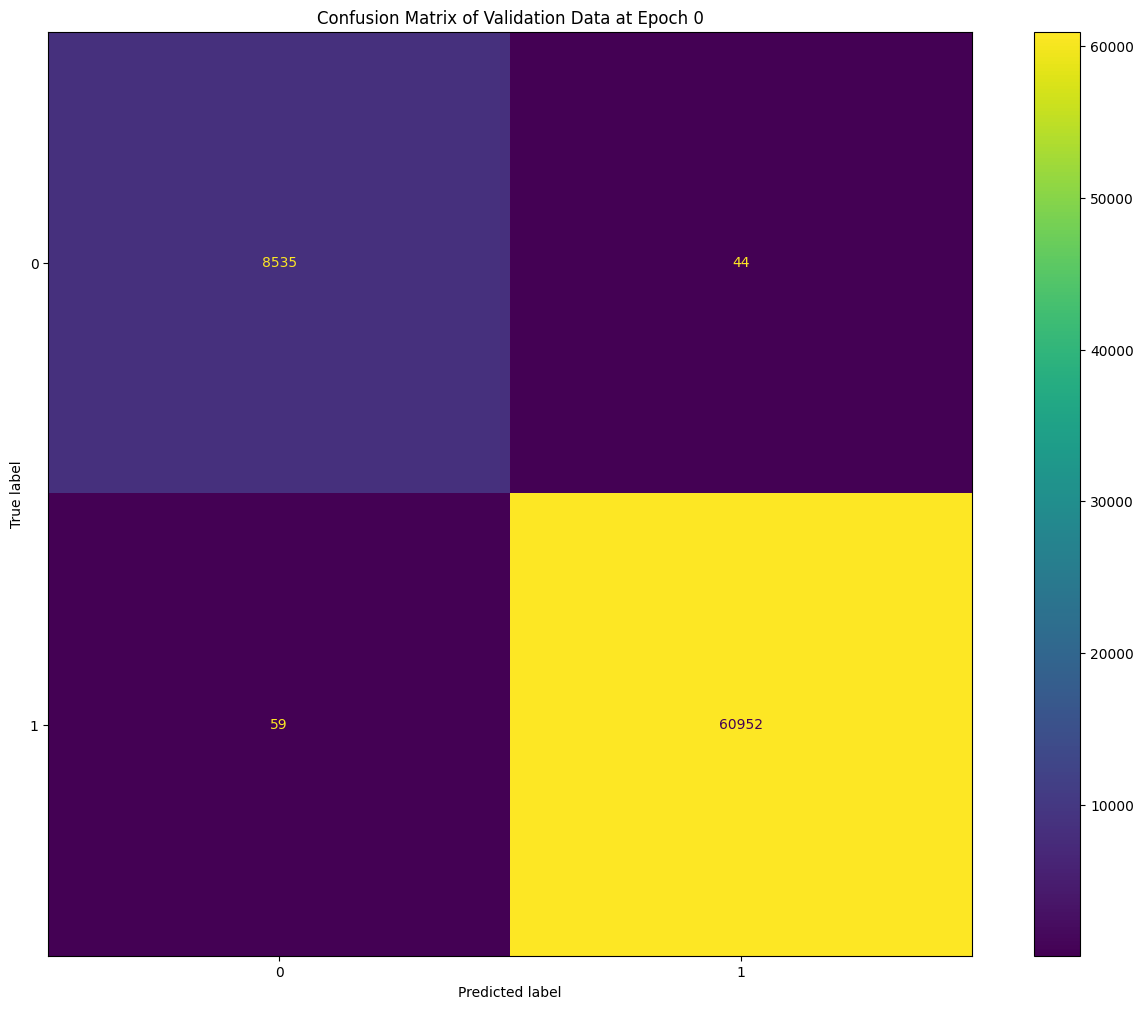

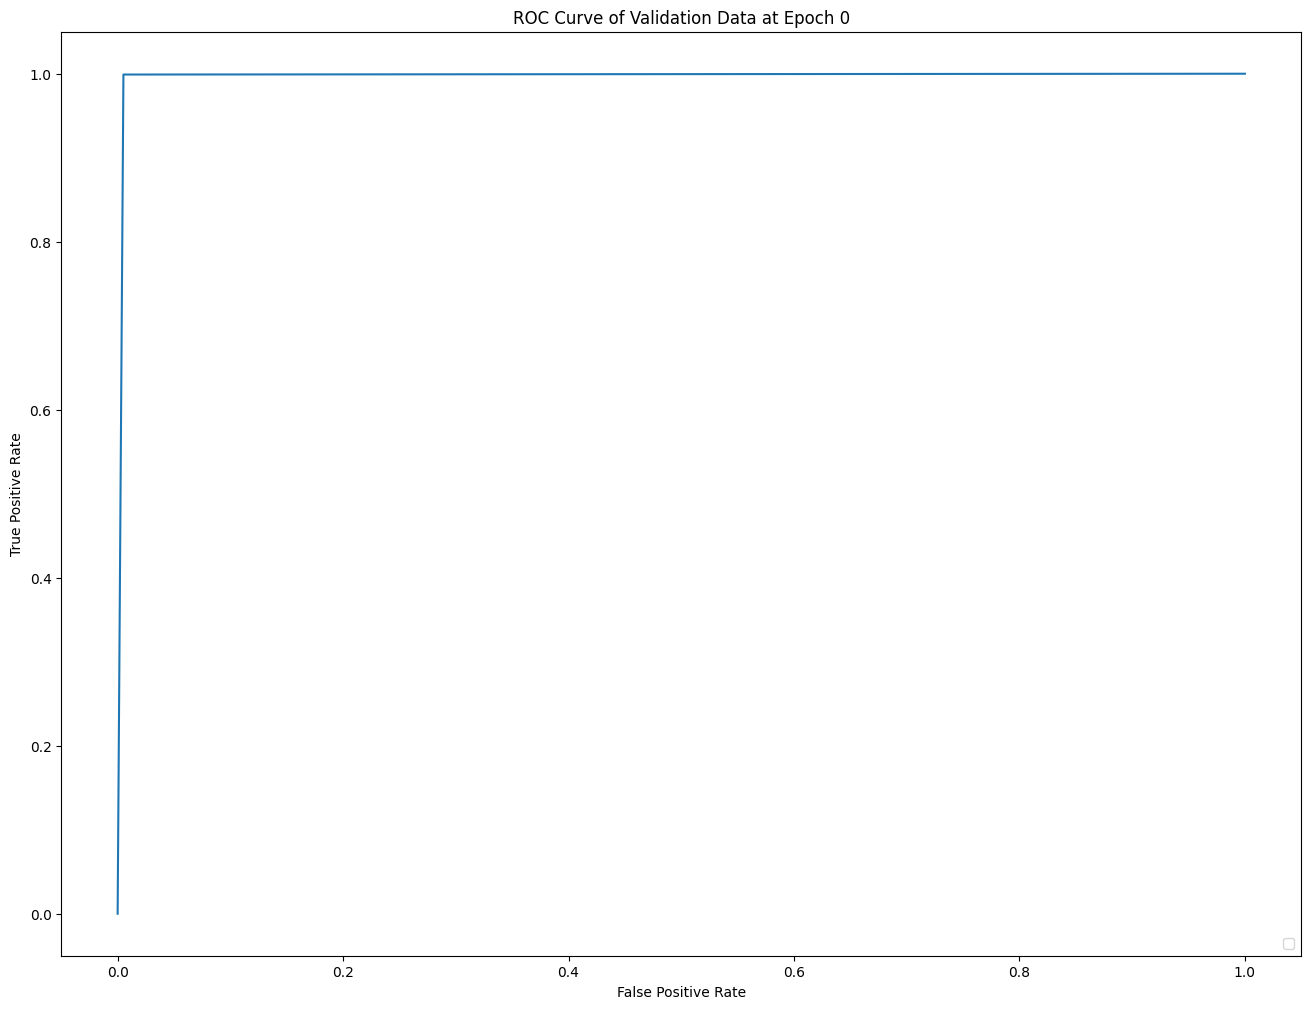

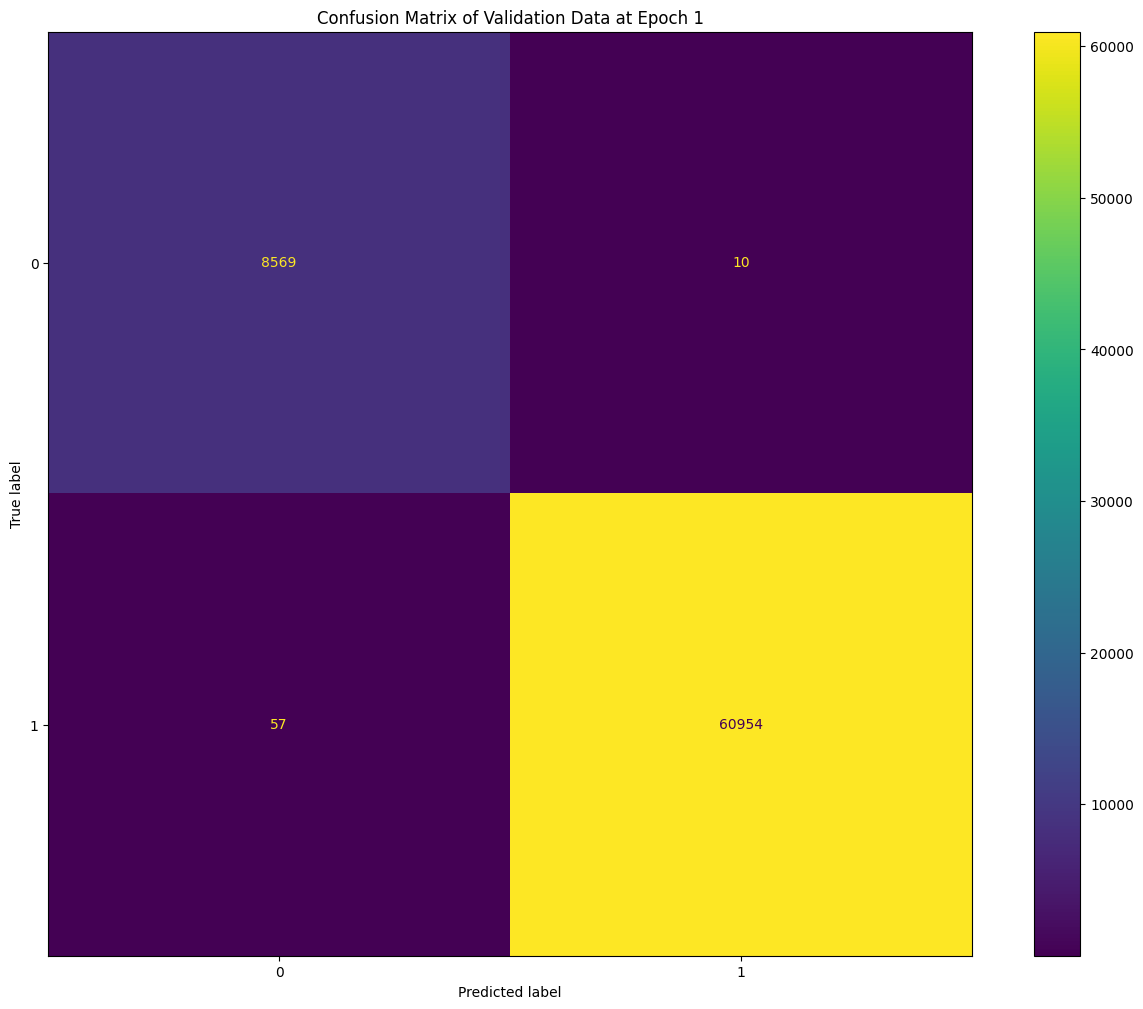

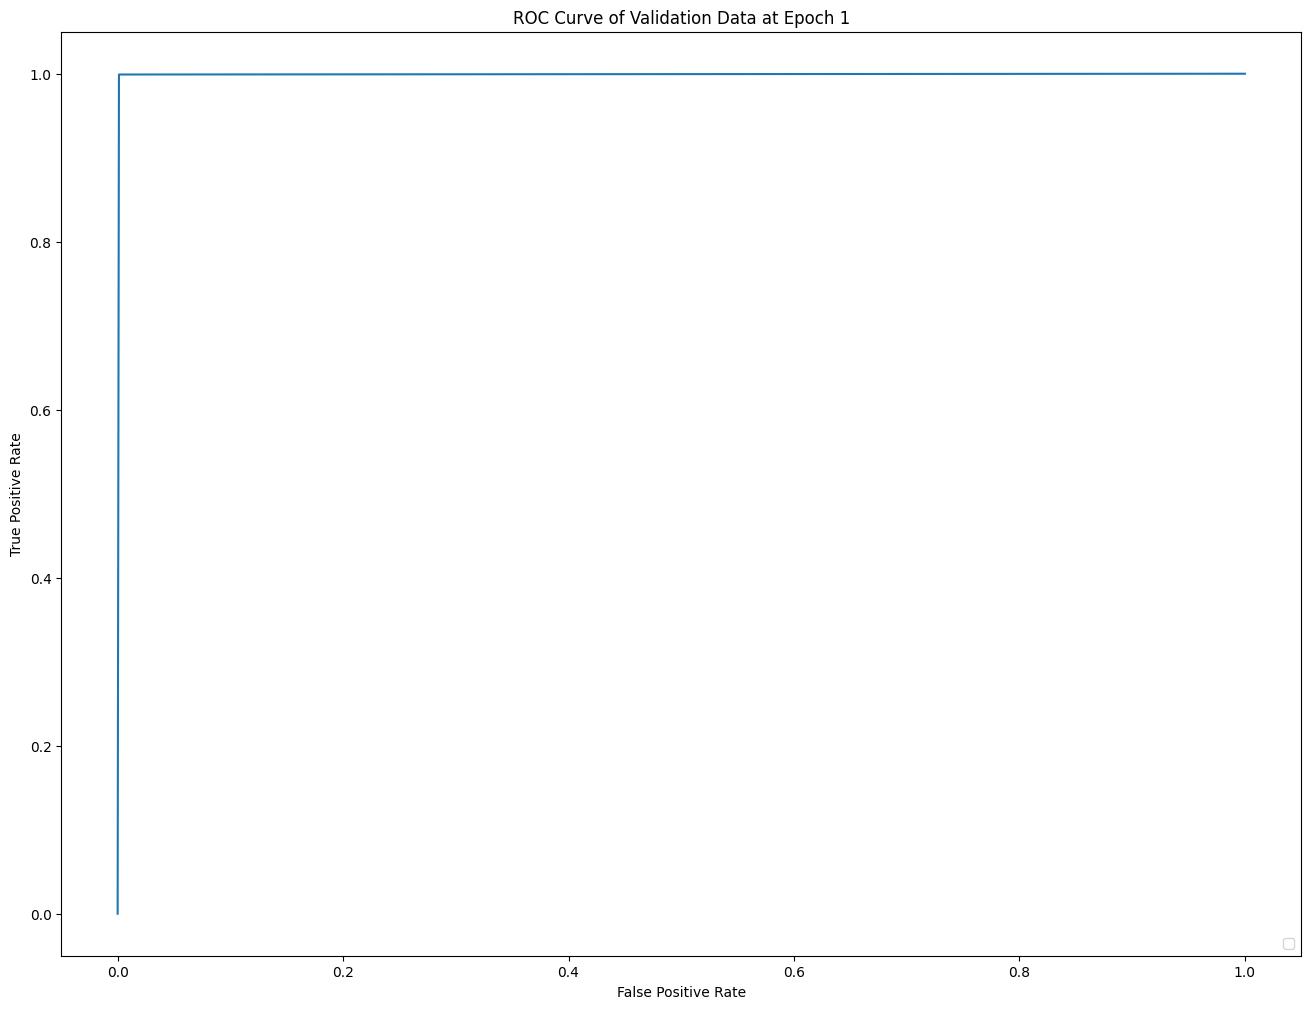

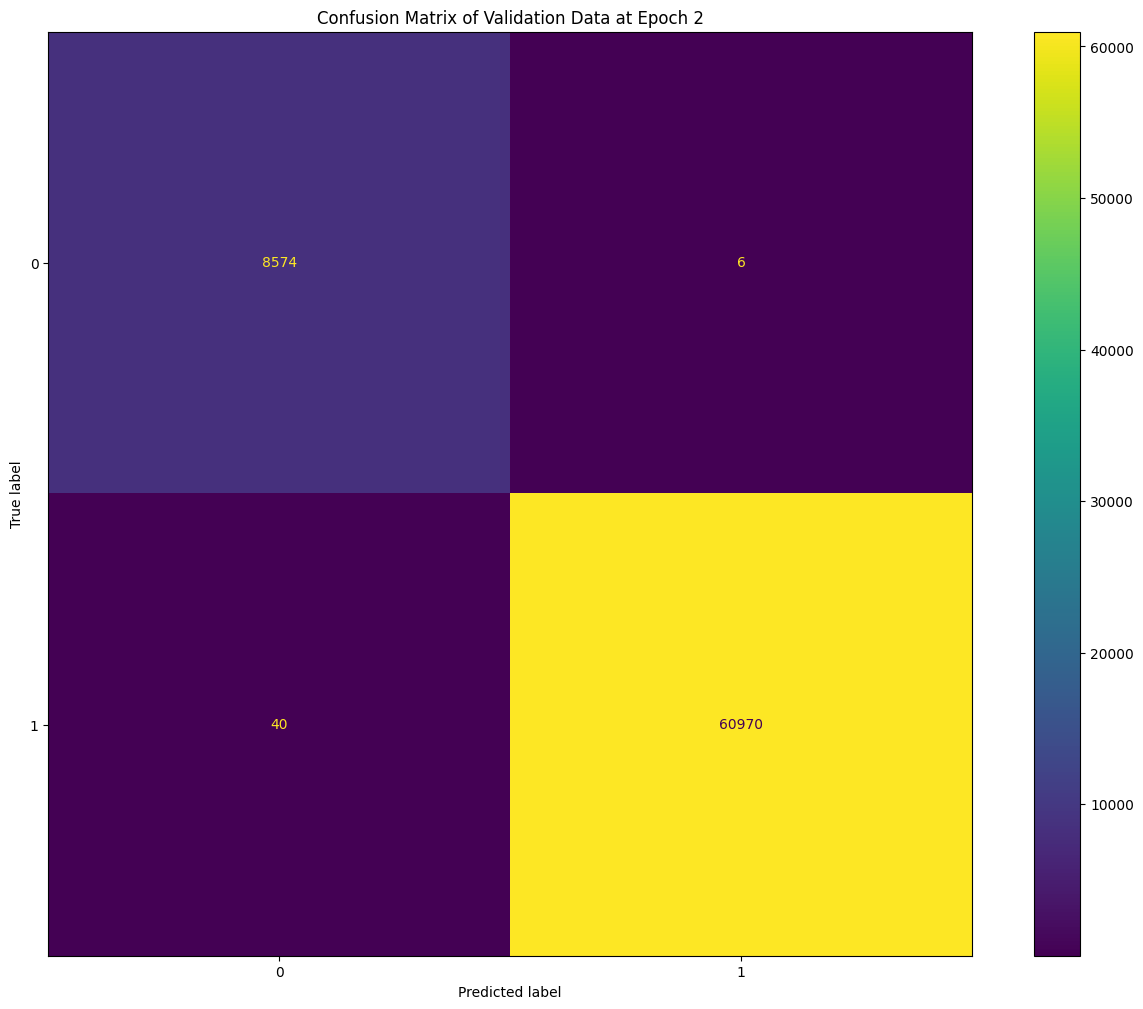

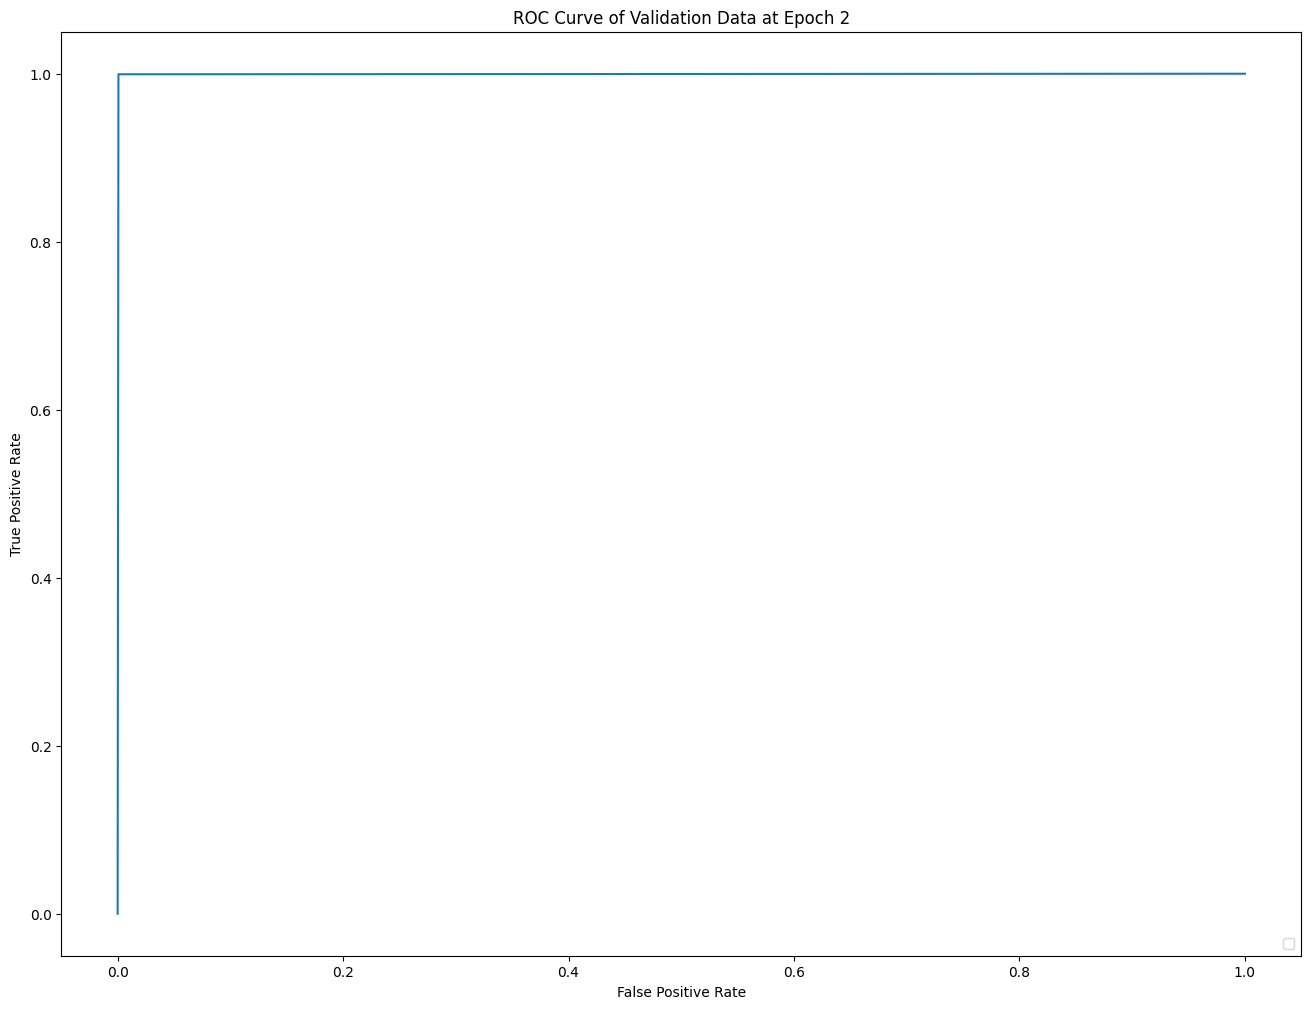

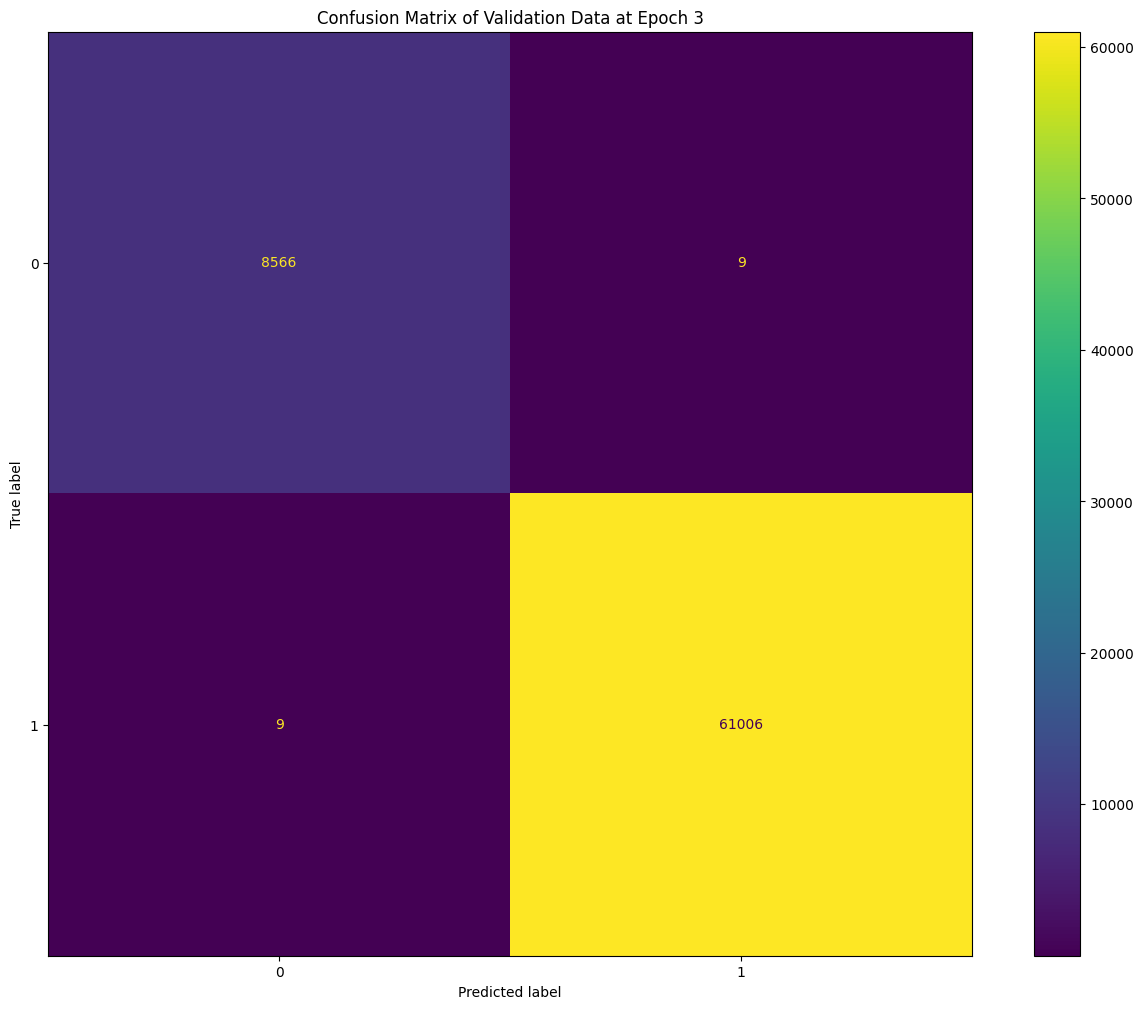

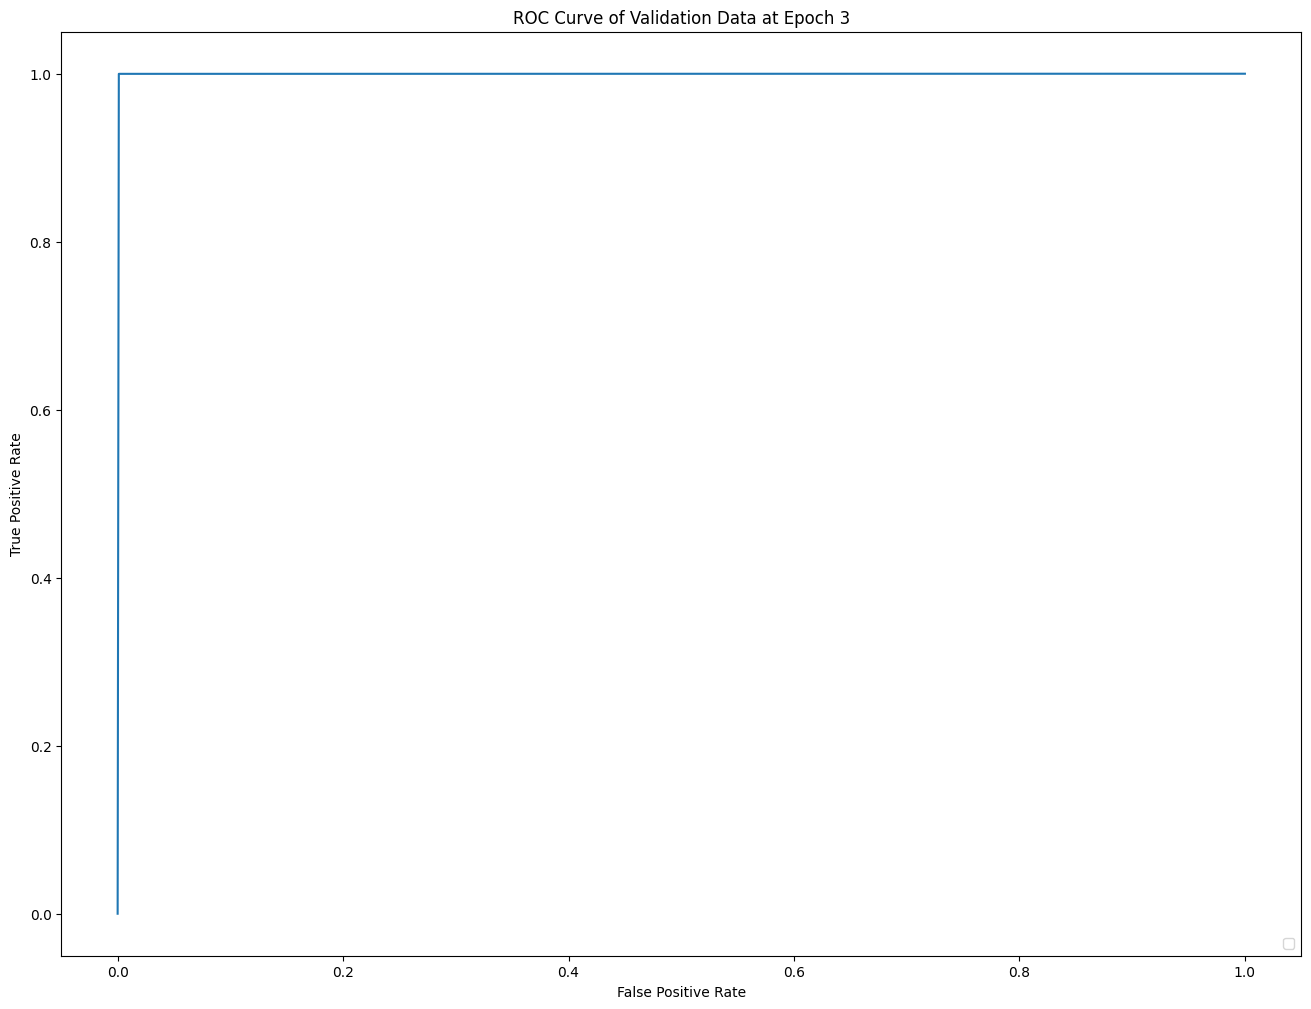

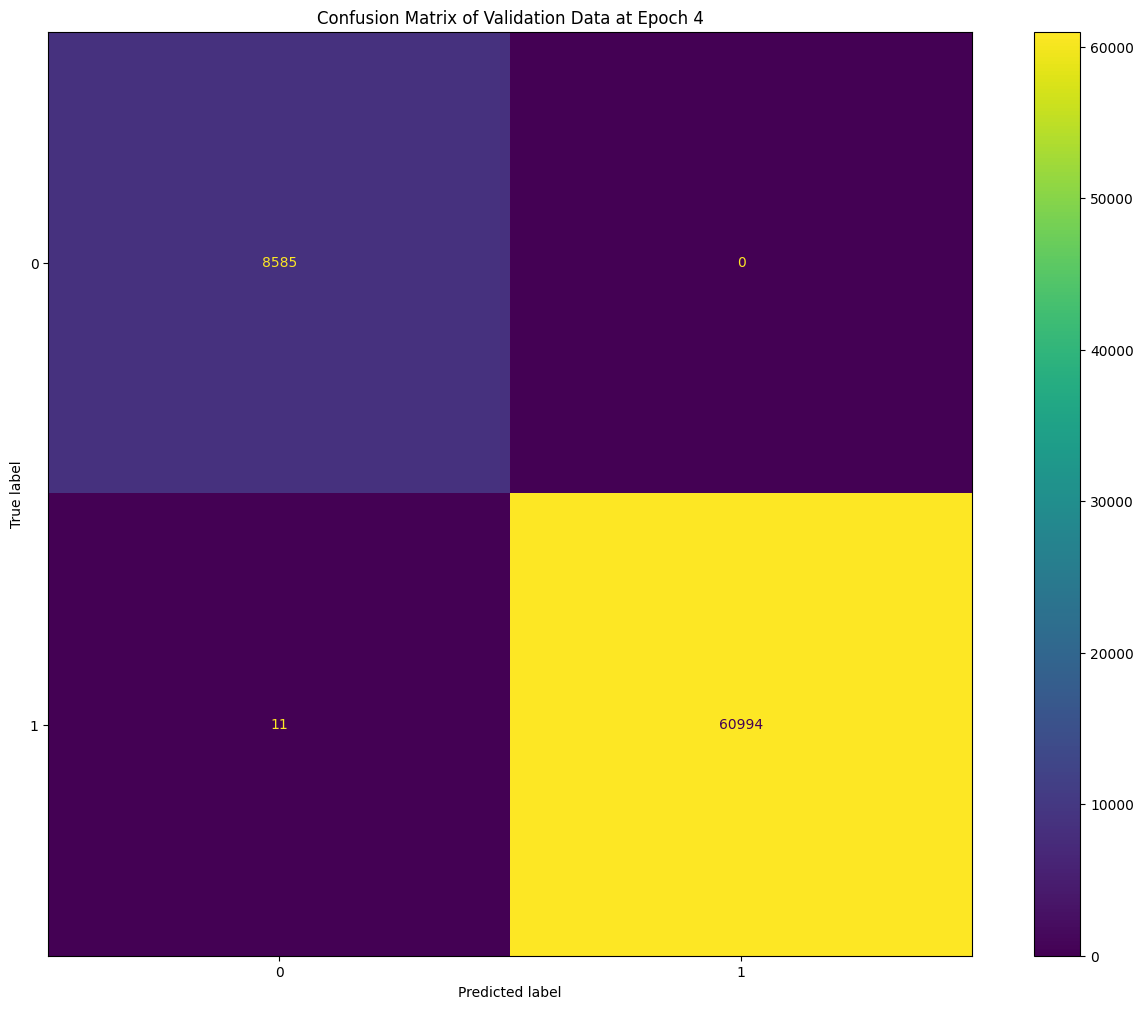

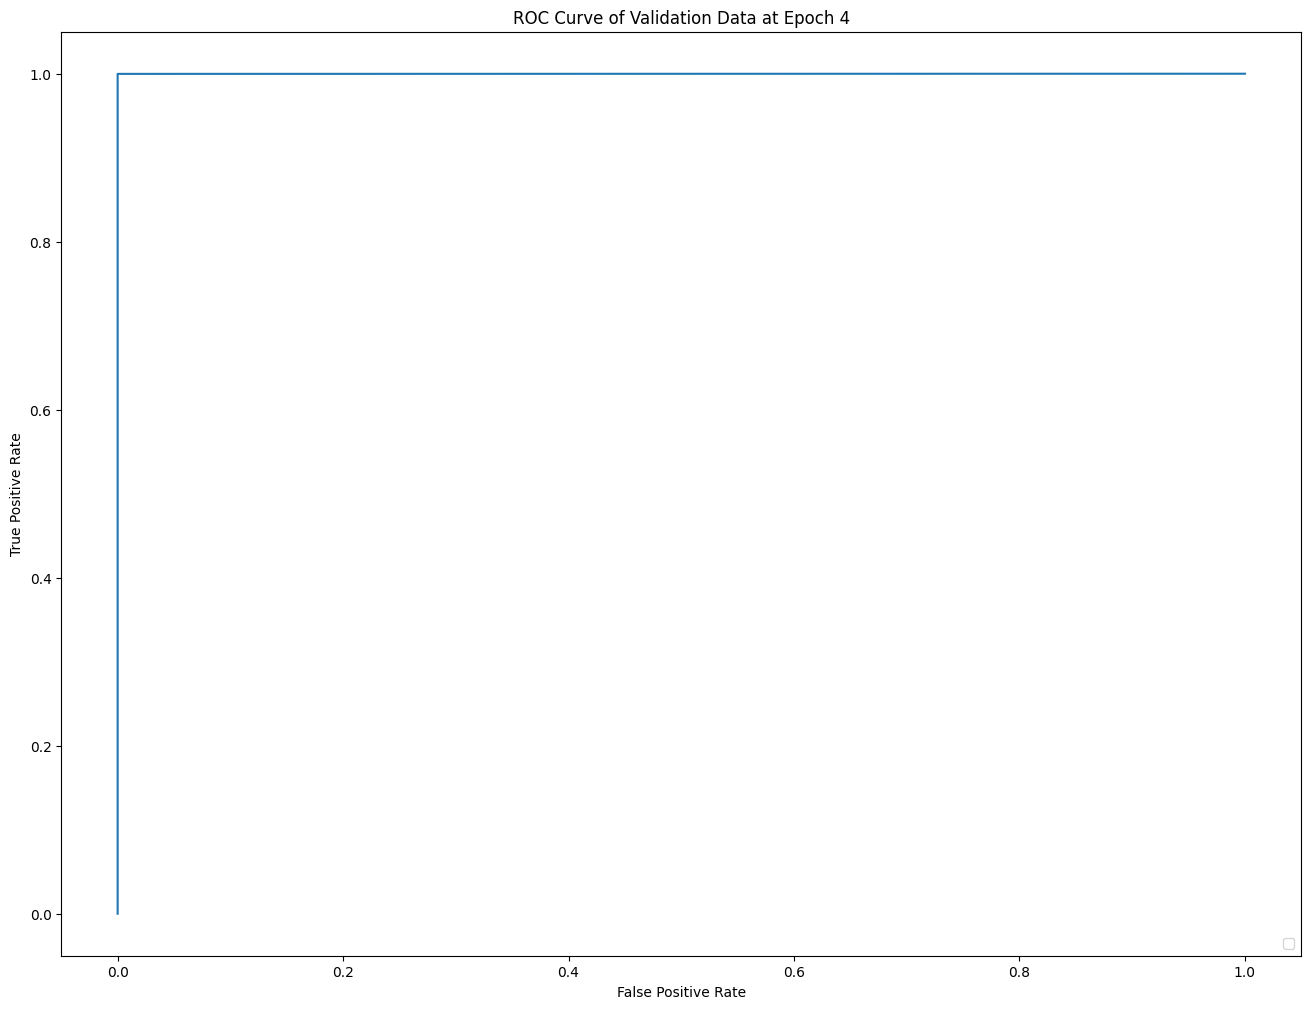

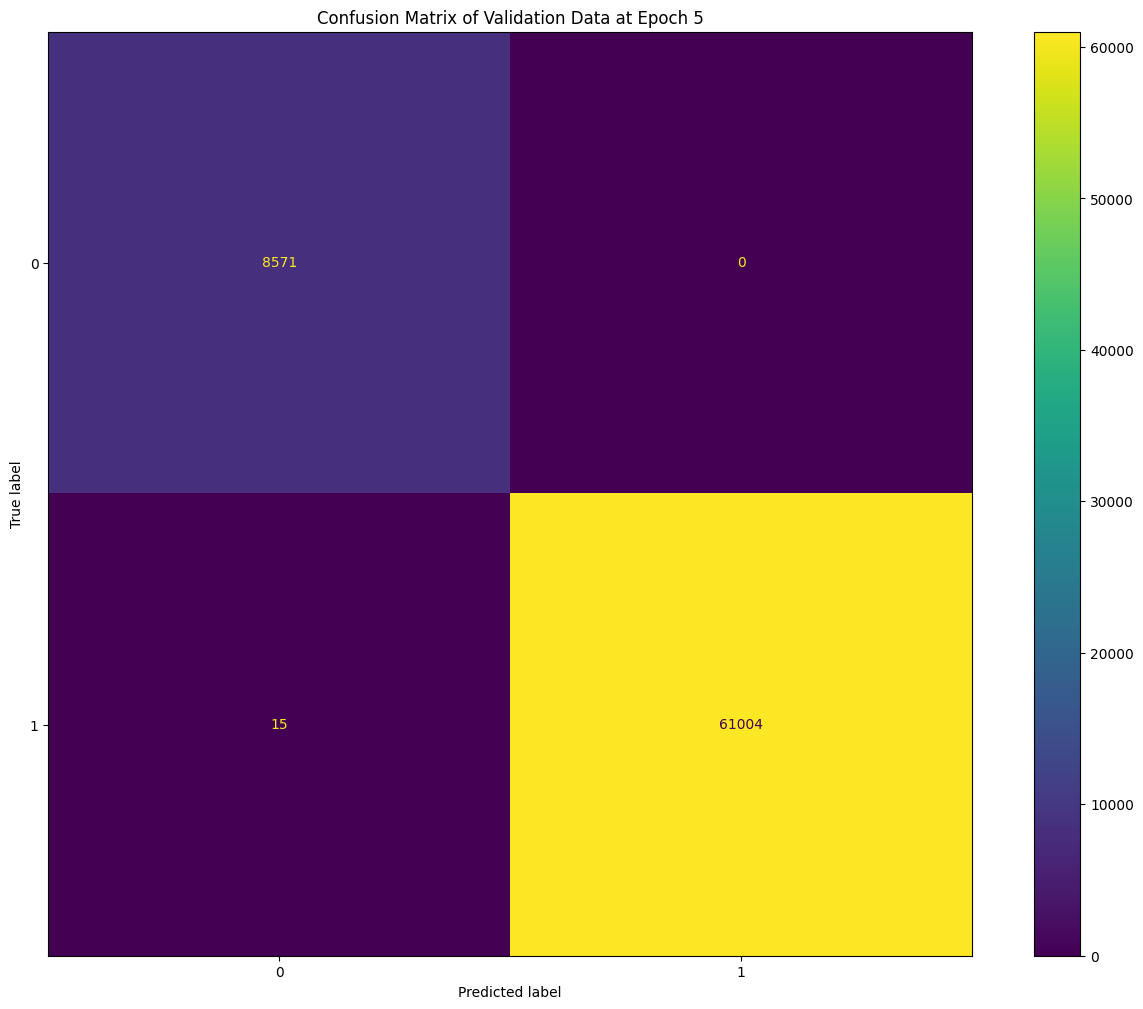

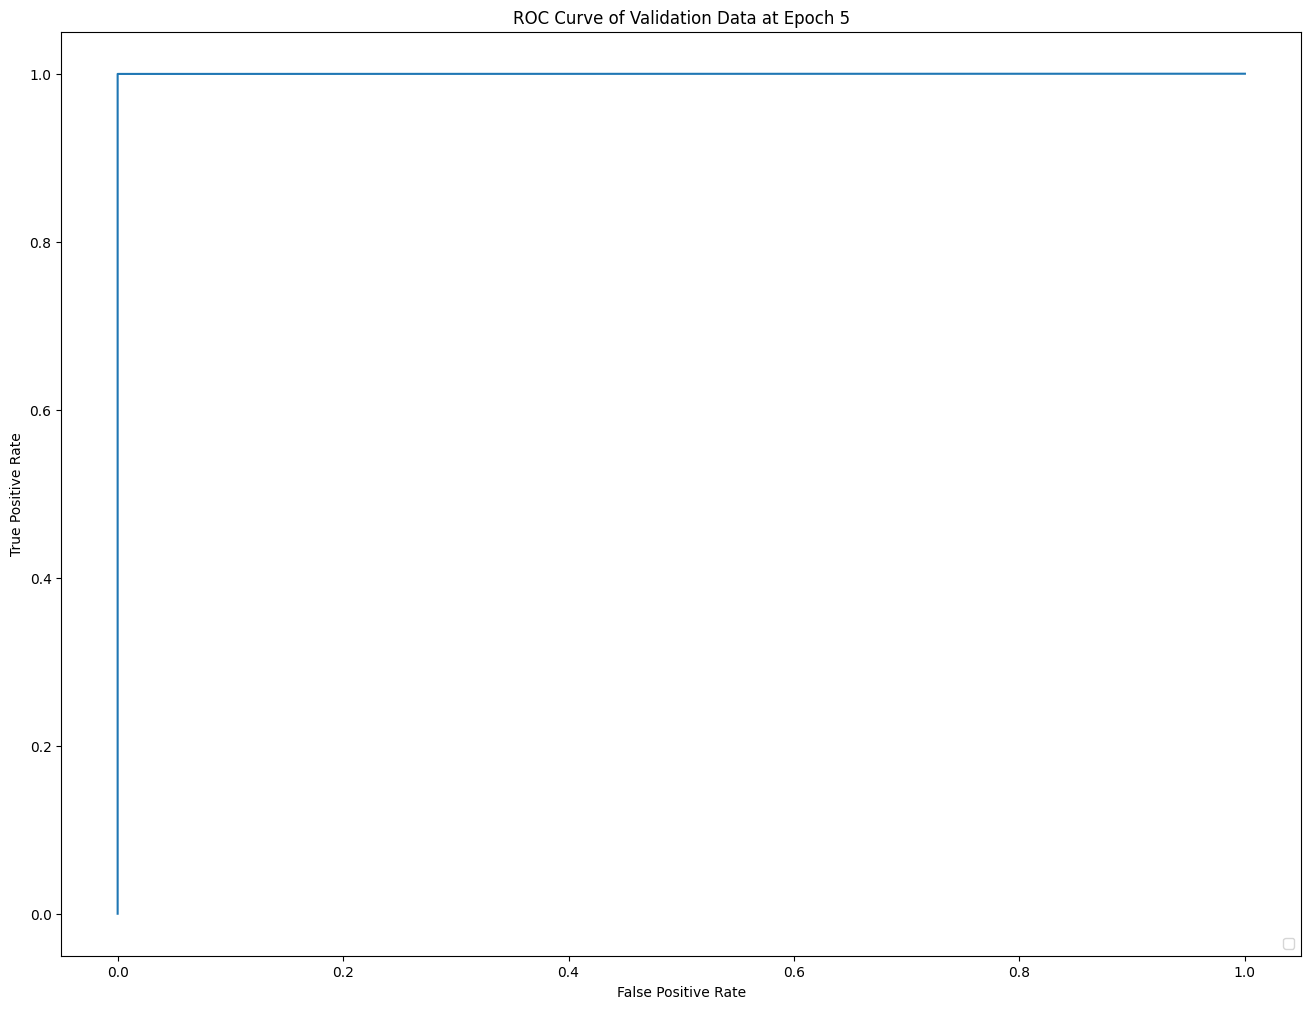

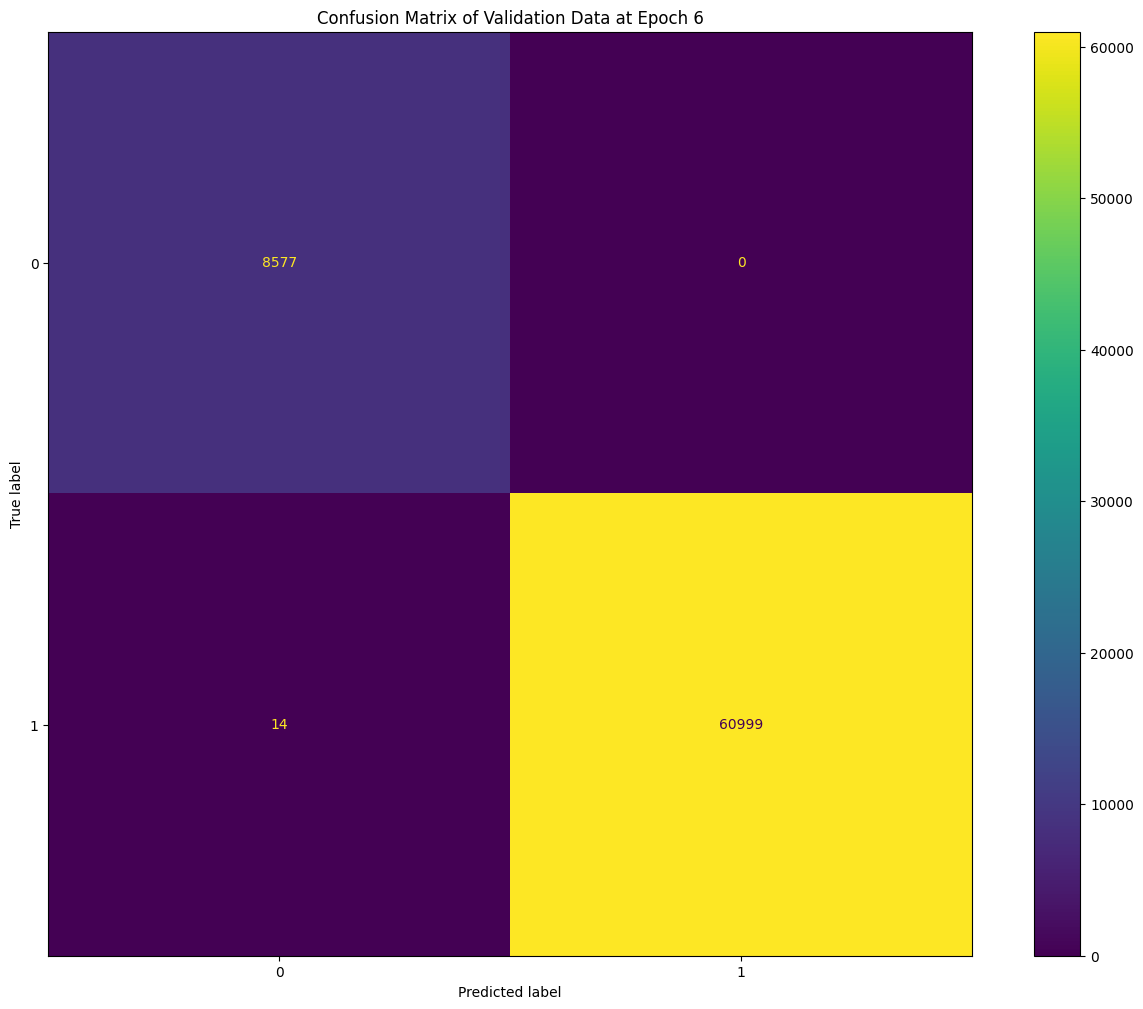

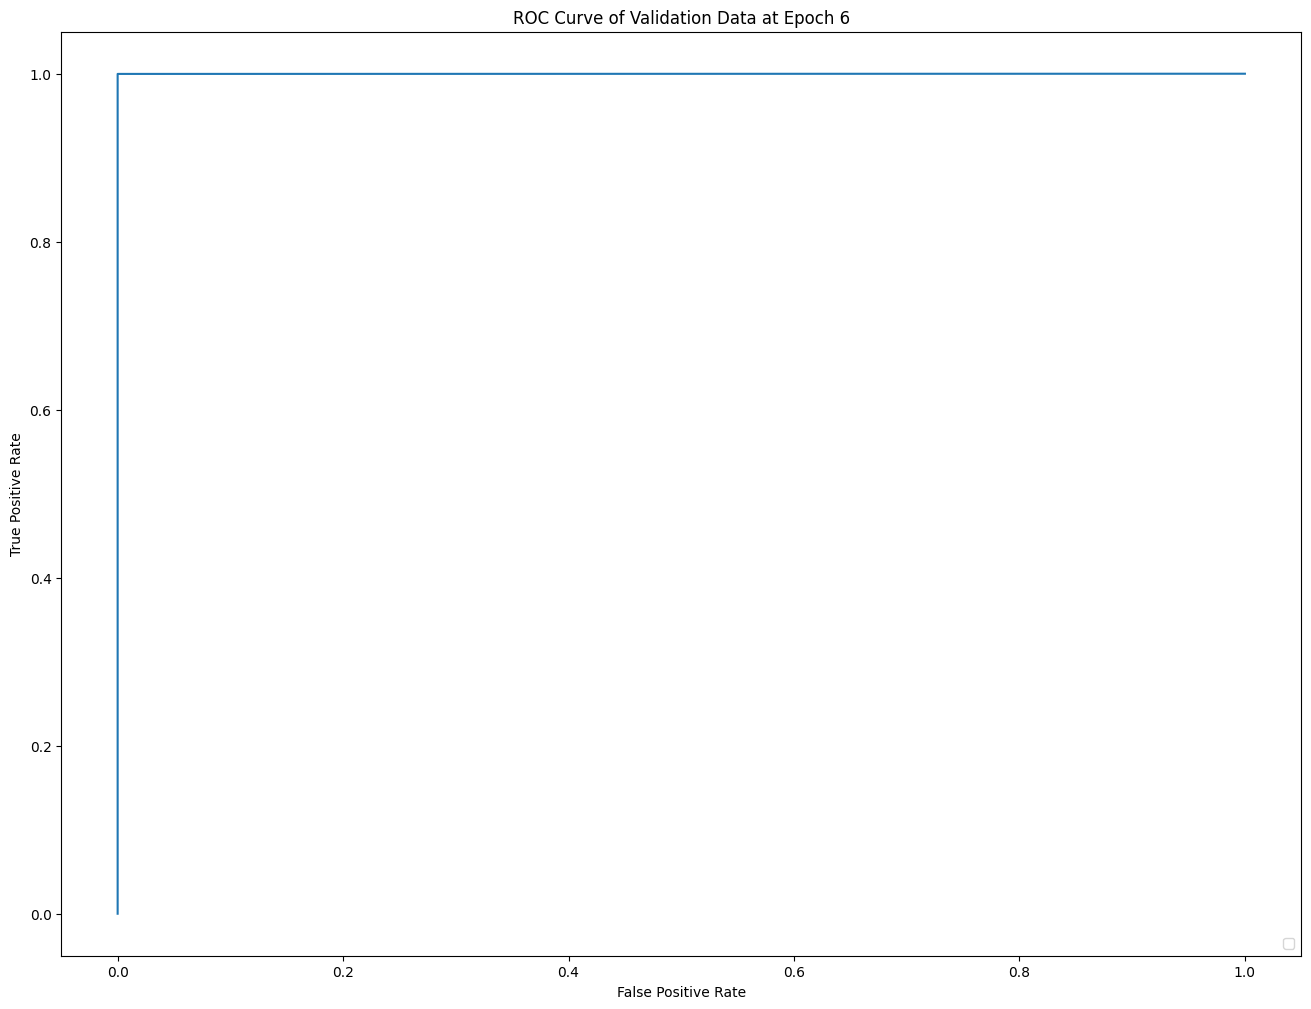

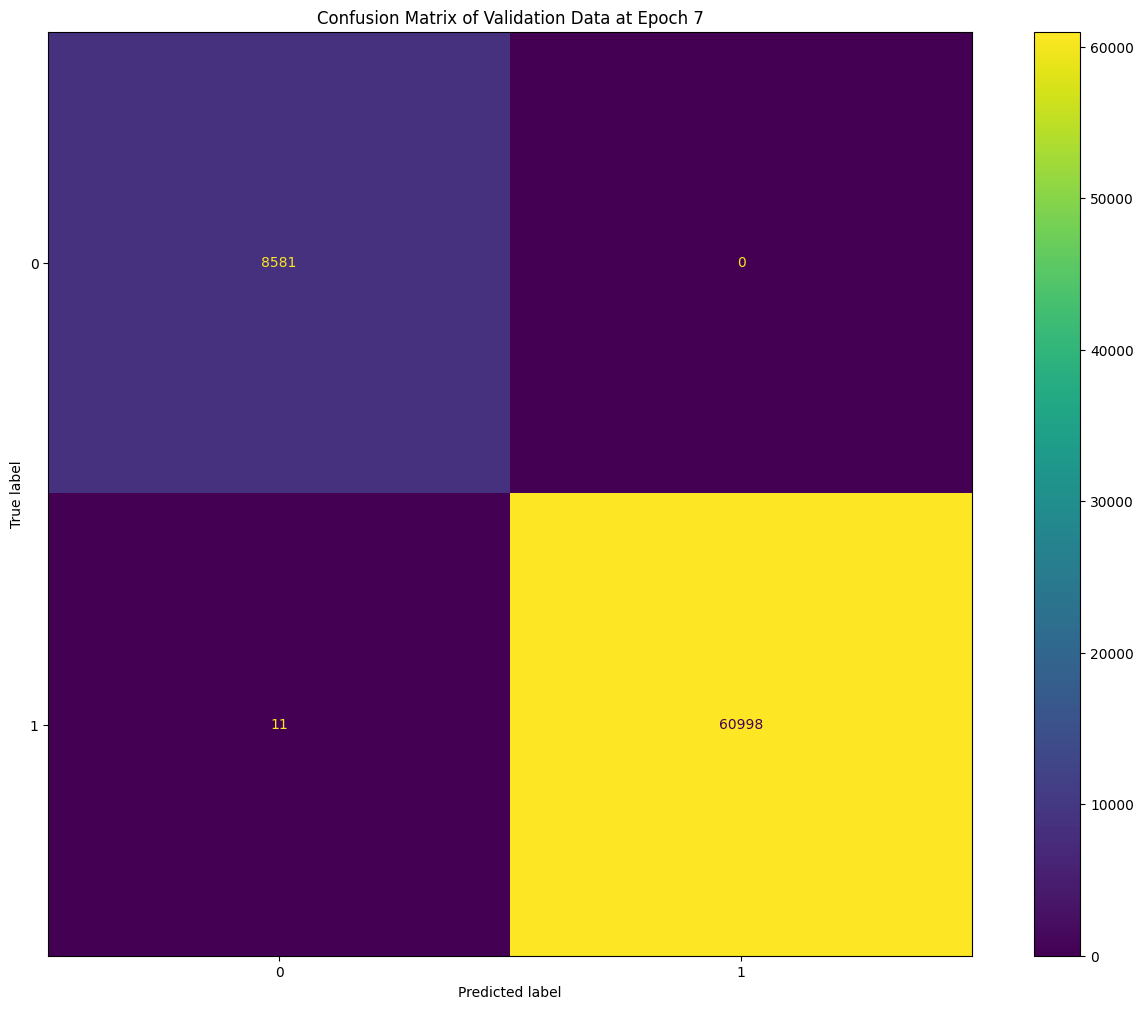

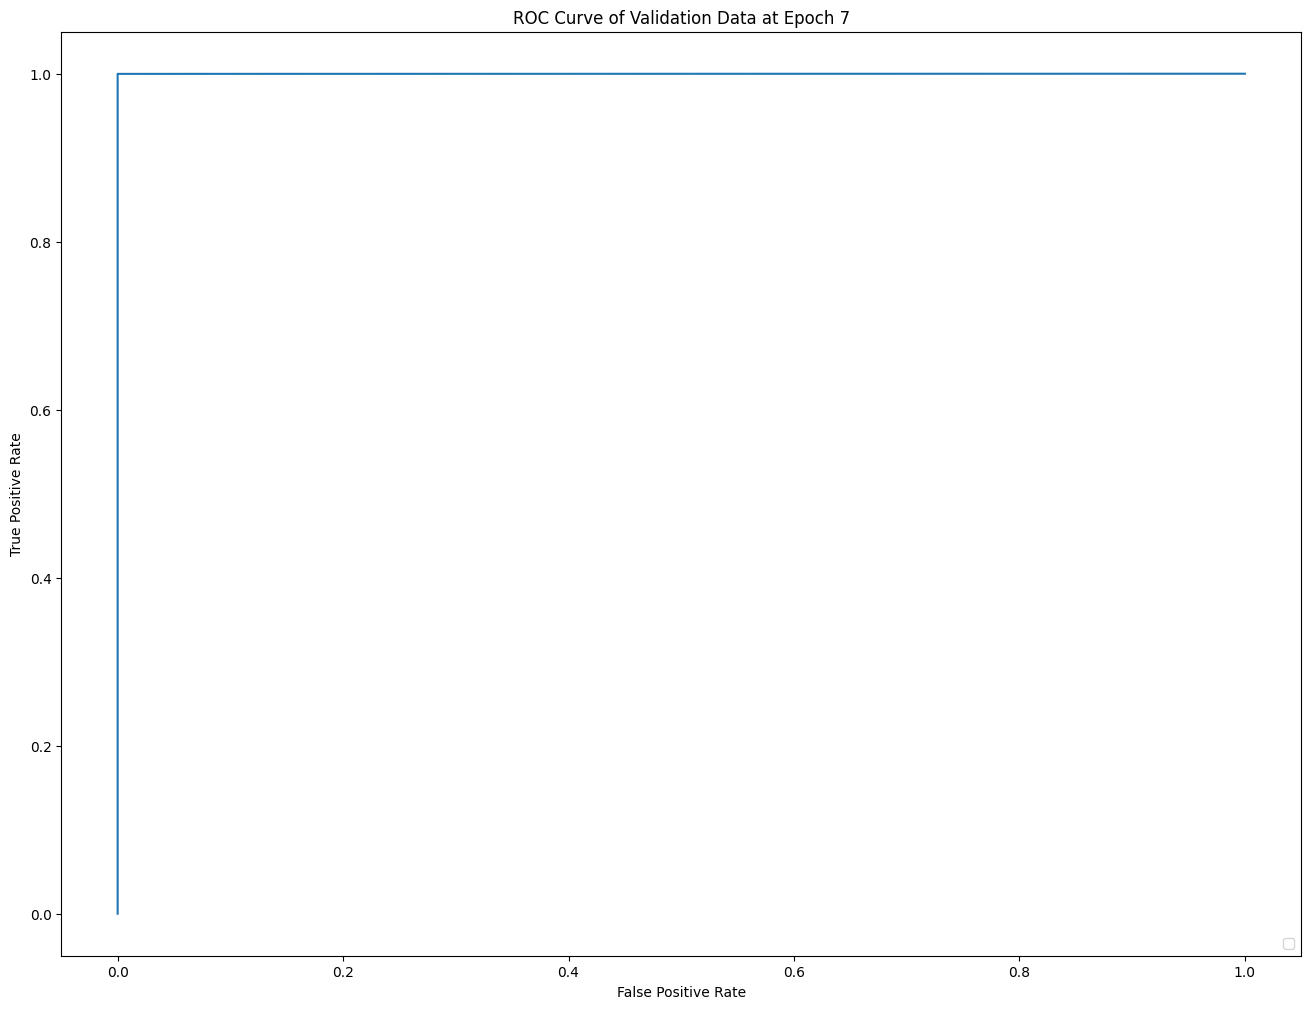

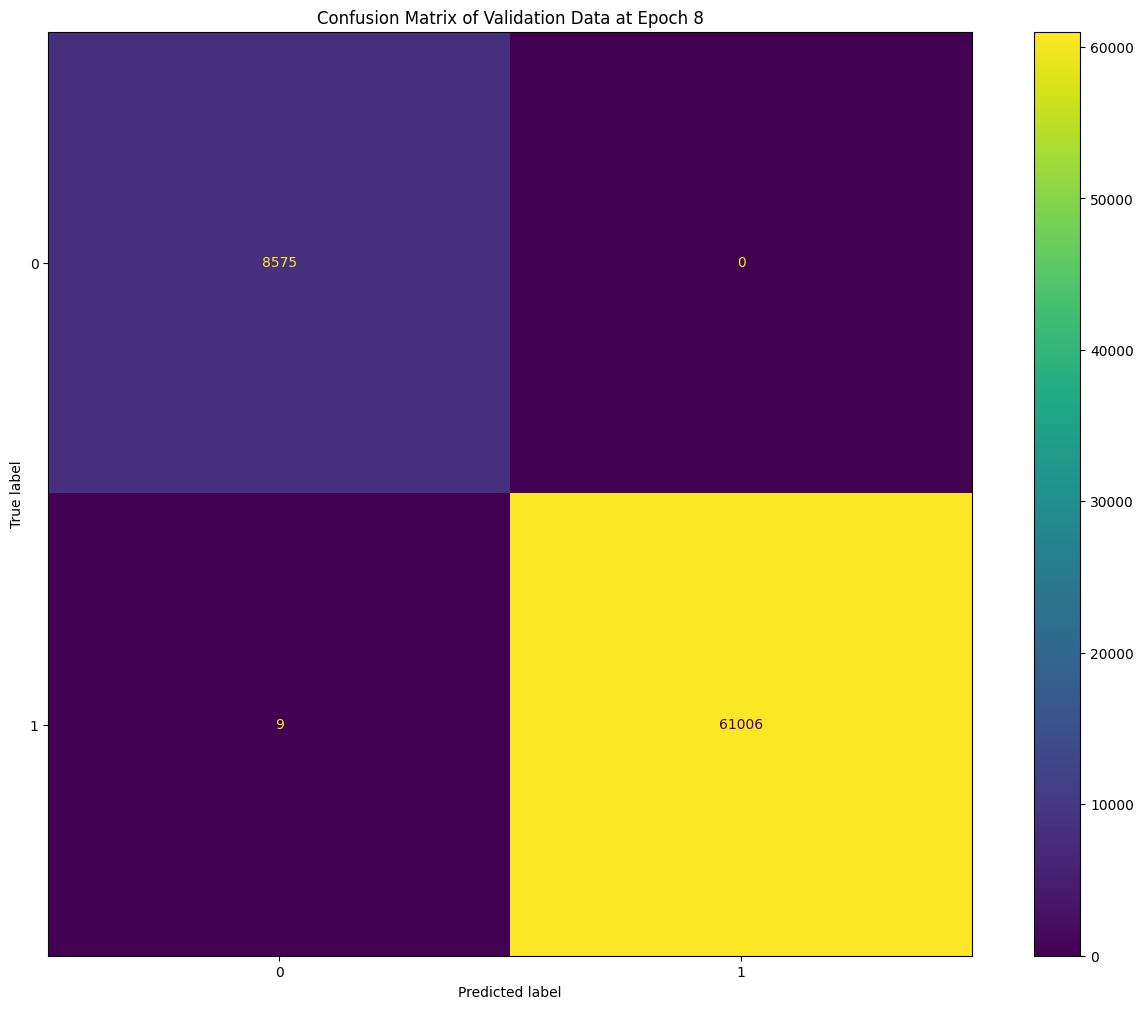

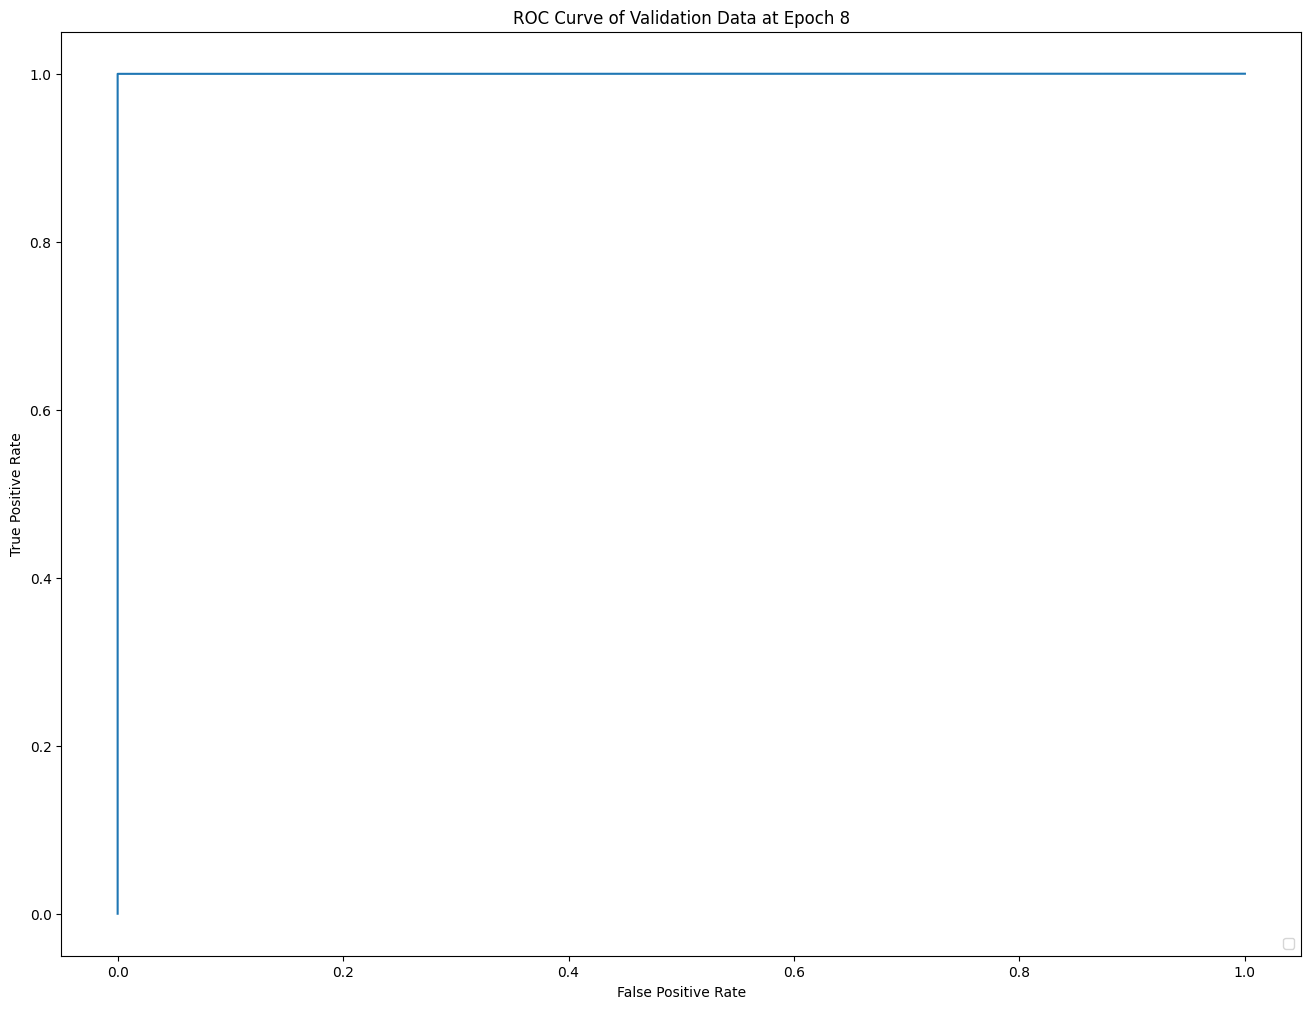

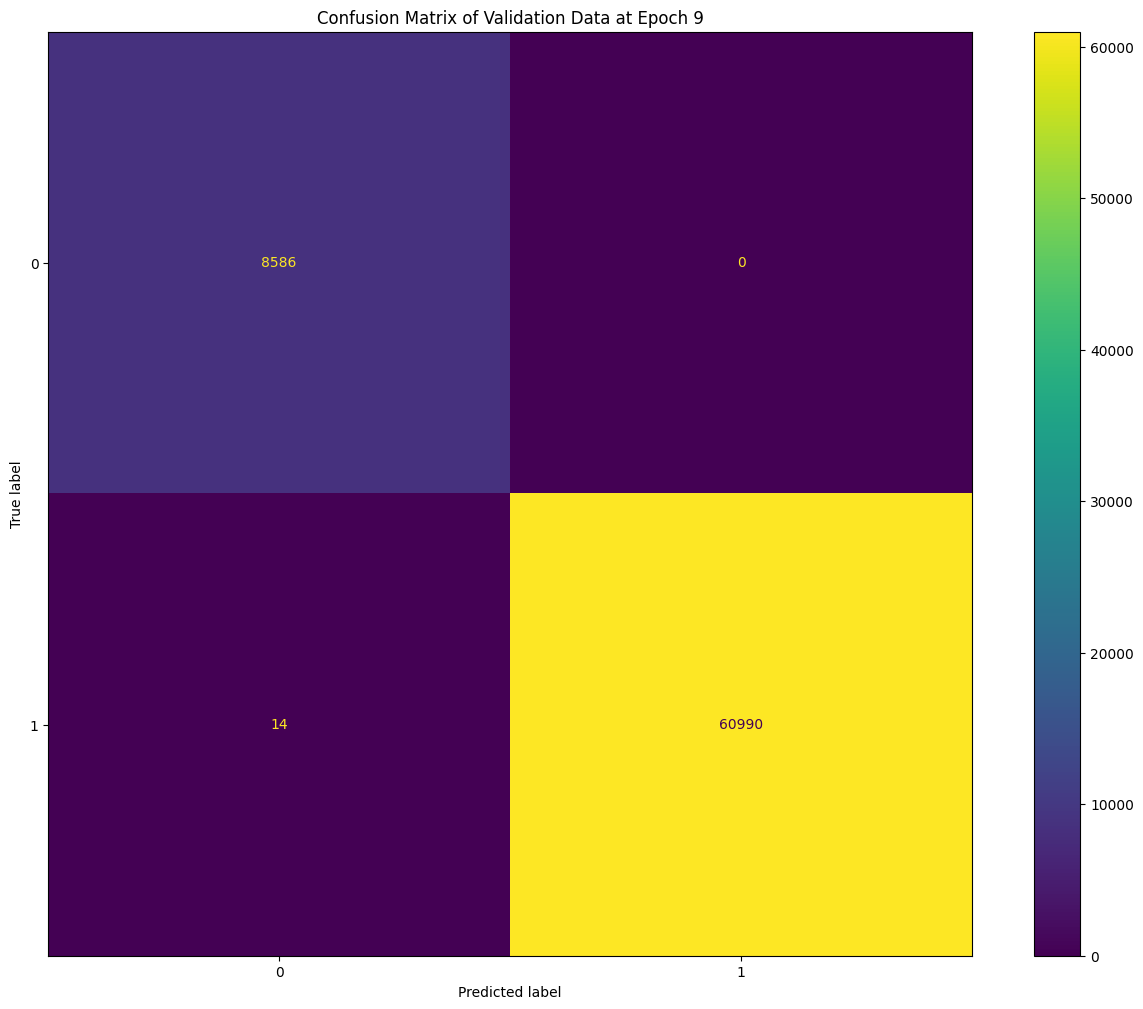

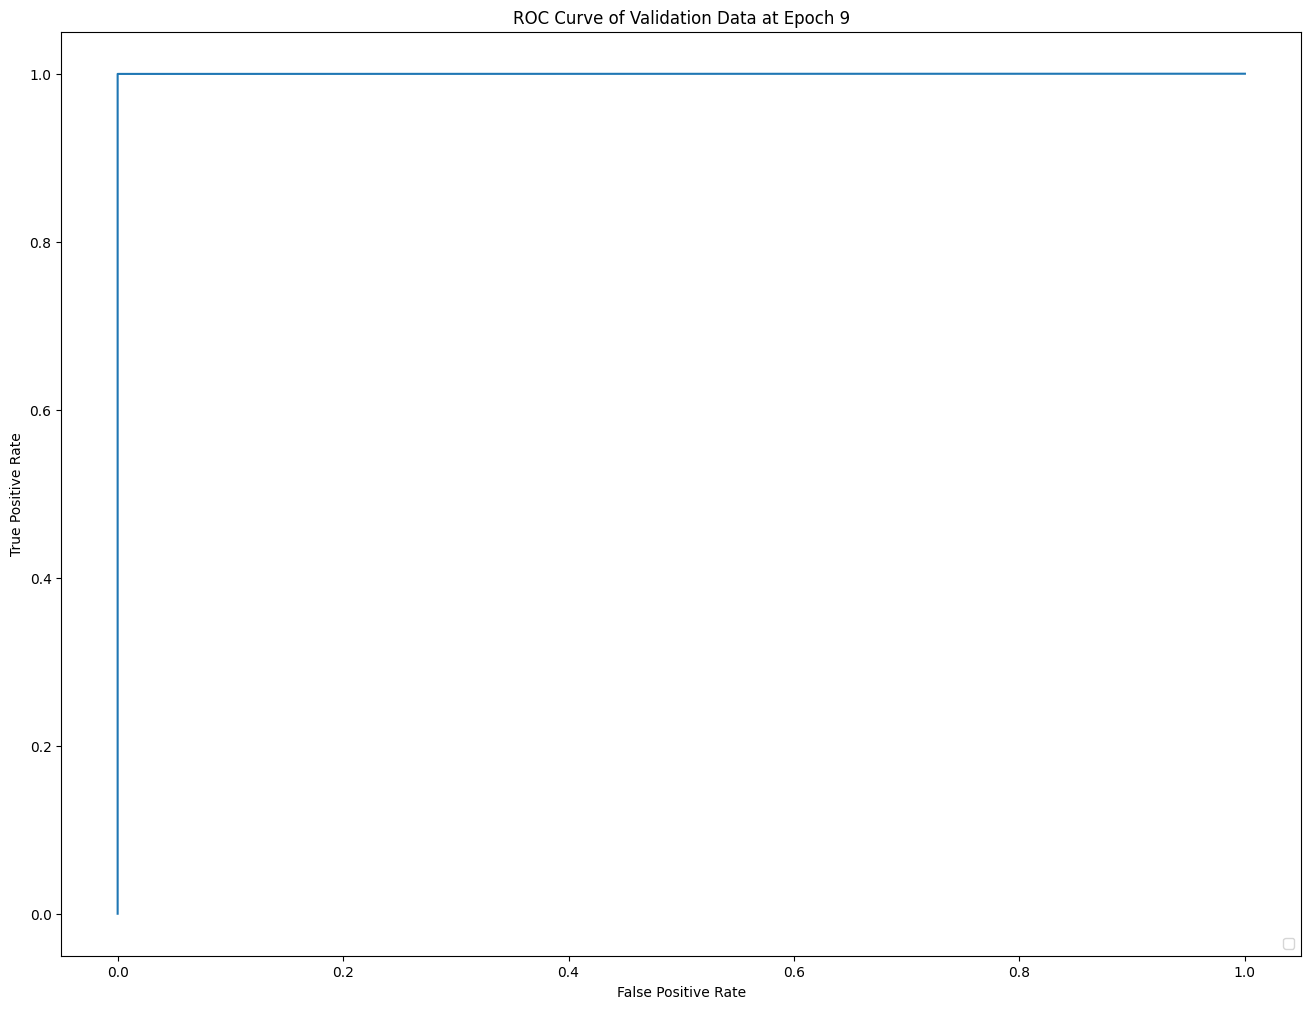

In [7]:
class SaveHistory(Callback):
    def __init__(self, filepath):
        super(SaveHistory, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filepath, 'wb') as file:
            pickle.dump(self.model.history.history, file)

# Create an instance of the custom callback
save_history_callback = SaveHistory('training_history.pkl')

num_epochs = 10

history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    callbacks=[performance_cbk, save_history_callback] #uncomment once you want to use it
)


In [8]:

model.save('GasNet-with-GAN/')

INFO:tensorflow:Assets written to: GasNet-with-GAN/assets


INFO:tensorflow:Assets written to: GasNet-with-GAN/assets


# Step 4: Evaluate the model on the Test Dataset

### Generate evaluation metrics and plots such as confusion matrix and ROC curves, F1 score, etc.

We are primarily concerned with high false positive rate due to the extreme class imbalance

In [11]:
predictions = model.predict(test_generator)

7402/7402 [==============================] - 139s 19ms/step


In [12]:
ground_truth_labels = test_generator.classes

In [30]:
threshold = 0.5
processed_preds = (predictions >= threshold).flatten().astype(int)

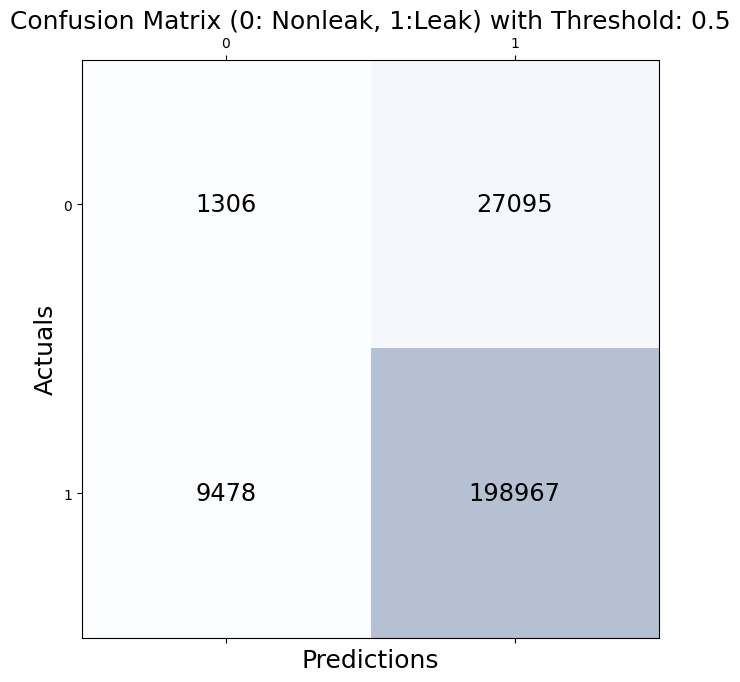

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=ground_truth_labels.astype(int), y_pred=processed_preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Confusion Matrix (0: Nonleak, 1:Leak) with Threshold: {threshold}', fontsize=18)
plt.show()

In [32]:
from sklearn.metrics import accuracy_score,f1_score
predicted_labels = predictions.argmax(axis=1)  # Convert predicted probabilities to class labels
accuracy = accuracy_score(ground_truth_labels, processed_preds)

In [33]:
accuracy

0.8455832059650574

In [34]:
f1 = f1_score(ground_truth_labels, processed_preds)
f1

0.9158287438407205

In [35]:
conf_matrix = confusion_matrix(ground_truth_labels, processed_preds)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

In [36]:
for label, acc in zip(['Nonleak', 'Leak'], per_class_accuracy):
    print(f"Class '{label}' Accuracy: {acc:.2f}")

Class 'Nonleak' Accuracy: 0.05
Class 'Leak' Accuracy: 0.95
